<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_in_colab_Datagenerator_from_Frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [46]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

rm: cannot remove 'sample_data': No such file or directory
--2019-06-04 19:24:49--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-06-04 19:24:49--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5214 (5.1K) [text/plain]
Saving to: ‘lib.py.1’

lib.py.1            100%[===================>]   5.09K  --.-KB/s    in 0s      

2019-06-04 19:24:50 (85.4 MB/s) - ‘lib.py

In [0]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
from google.colab import widgets
import google.colab.widgets as colab_widgets
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import PIL
import json
import lib
import os 
import pickle # people say import sPickle as pickle is faster

# Intro



## Encoding
X.shape = (samples, 224, 224, 3)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [48]:
#@title Common Stuff { vertical-output: true } 
image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (6)

print('input_shape', input_shape, 'output_shape', output_shape)

input_shape (224, 224, 3) output_shape 6


In [0]:
max_count       = output_shape
fig_id_format   = '%s/fig%06d'
fig_path_format = './figures/%s.pkl'
png_path_format = './images/%s.png'

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(fid, fig):    
    os.makedirs('./figures/%s'%fid.split('/')[0], exist_ok=True)
    #print("create ir", path)
    with open(fig_path_format%fid, 'wb+') as dbfile:
        pickle.dump(fig, dbfile)               

def load_figure(fid):
    with open(fig_path_format%fid, 'rb') as dbfile:
        return pickle.load(dbfile)

def load_pil(fid):
    return PIL.Image.open(png_path_format%fid).resize(image_shape, PIL.Image.LANCZOS)    

def save_pil(fid, pil):
    os.makedirs('./images/%s'%fid.split('/')[0], exist_ok=True)
    pil.save(png_path_format%(fid))

def load_image(path): # used to predict image which are not in sets (like parrot)
    return PIL.Image.open(path).resize(image_shape, PIL.Image.LANCZOS)

to_onehot    = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
count_color  = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape  = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)
count_size   = lambda f, c: reduce(lambda a, e: a + (1 if e.size > c[0] and e.size <= c[1] else 0), f, 0)
to_line_list = lambda dic:"\n\t".join("{:}: {},".format(k, v) for k, v in dic.items())

# Sample *s*

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}


,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

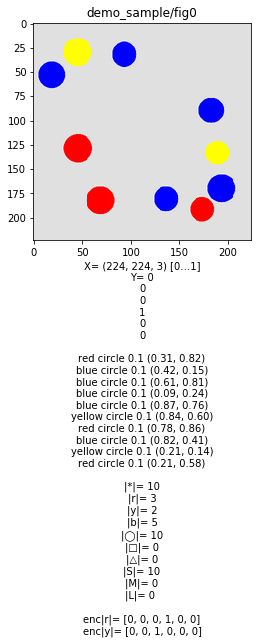

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

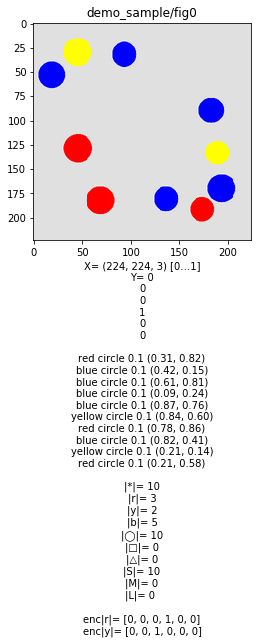

<IPython.core.display.Javascript object>

In [50]:
#@title Create a Sample { vertical-output: true }

default_figure_config = dict(   
    render_size = image_shape,
    obj_count = (2, 15),     
    obj_size = (.1, .5),
    colors = ['red','yellow', 'blue'], #['red','green', 'blue', 'yellow', 'orange'],
    shapes = ['circle']
)

class Sample:  
    def __init__(self, id, fig_cfg=None):
        #print('touching sample %s/%d'%(set_path, fid))        
        self.ID = id        
        self.f_config = fig_cfg
        self.f, pil = self.loadOrGenerate()            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.counts = {            
            '|*|': len(self.f),
            '|r|': count_color(self.f ,'red'),
            '|y|': count_color(self.f ,'yellow'),
            '|b|': count_color(self.f ,'blue'),
            '|◯|': count_shape(self.f ,'circle'),
            '|□|': count_shape(self.f ,'rectangle'),
            '|△|': count_shape(self.f ,'trinangle'),
            '|S|': count_size(self.f , (.1, .2)),
            '|M|': count_size(self.f , (.2, .4)),
            '|L|': count_size(self.f , (.4, .5)),
        }                
        self.encoded = {
            #'encpos':   to_onehot(self.f_config.pos, 3),            
            #'enc|*|':   to_onehot(self.counts['|*|'], max_count),            
            #'enc|yL△|': to_onehot(count large yellow triangles),
            #'enc|yS△|': to_onehot(count ),
            #'enc|y△|': to_onehot(count ),
            'enc|r|':    to_onehot(self.counts['|r|'], max_count),            
            'enc|y|':    to_onehot(self.counts['|y|'], max_count),            
            #'enc|y△ left|': to_onehot(count ),
            #'enc|y△ top|': to_onehot(count ),            
            #'enc|y△ ontop r△|': to_onehot(count ),
            #'cap': []
        }        
    
    def loadOrGenerate(self):
        if os.path.isfile(fig_path_format%self.ID):
            self.f = load_figure(self.ID)                                       # schnell
        else:
            self.f = lib.RandomFigure(**self.f_config)
            save_figure(self.ID, self.f)                                        # nicht so schnell
            
        if os.path.isfile(png_path_format%self.ID):
            pil = load_pil(self.ID)                                             # ok vermutlich
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=image_shape[0])      # ok
            save_pil(self.ID, pil)
        
        return self.f, pil
    
    def __str__(self):        
        return "%s"%self.ID
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):
        #return [ *self.encoded['enc|*|'], *self.encoded['enc|r|'] ]
        return self.encoded['enc|r|'] 
                
    def compilePandaColumns(self):
        return { 
            **{
                'ID': self.ID, 
                'file': "%s.png"%self.ID.split('/')[1],
                #'Xshape': self.x['arr'].shape, 
                'Yreadable': '%d red circles'%self.counts['|r|']
            },
            **self.counts,
            **self.encoded
        }
    
    def plot(self, verbose=0, title_prefix=None, X=None, Y=None):
        X = X if X is not None else self.x['arr']         
        Y = Y if Y is not None else self.compileY()        
        fig_str =  '\n'.join([str(f) for f in self.f])
        x_dim =    '%s [%.0f…%.0f]'%(X.shape, np.min(X), np.max(X))
        counts =   '\n'.join(['%s= %s'%(k, v) for k, v in self.counts.items()])
        encoded =  '\n'.join(['%s= %s'%(k, v) for k, v in self.encoded.items()])        
        
        #plt.xlabel('\n'.join([x_dim, y_str, fig_str, counts, encoded]))
        if verbose == 0: plt.xlabel('X= %s\nY= %s'%(x_dim, Y))        
        if verbose == 1: plt.xlabel('X= %s\nY= %s\n\n%s'%(x_dim, Y, counts))        
        if verbose == 2: plt.xlabel('X= %s\nY= %s\n\n%s\n\n%s \n\n%s'%(x_dim, Y, fig_str, counts, encoded))        
            
        plt.imshow(X)
        plt.title('\n'.join([ *([title_prefix] if title_prefix else []), str(self)]))        
        plt.show()
        
print("Figure Configuration= {\n\t%s\n}"%to_line_list(default_figure_config))

grid = widgets.Grid(1, 2)
with grid.output_to(0, 0):
    example = Sample('demo_sample/fig0', default_figure_config)
    example.plot(verbose=2)        

with grid.output_to(0, 1):
    example_loaded = Sample('demo_sample/fig0', default_figure_config)
    example_loaded.plot(verbose=2)

 # Sample Set

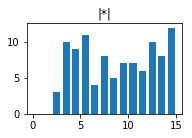

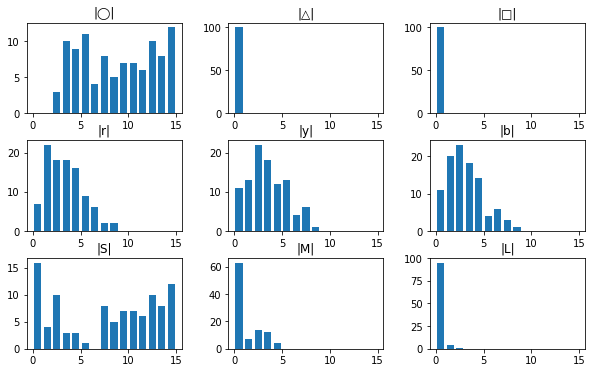

In [51]:
#@title First Batch { vertical-output: true }

def generate_batch(set_path, figure_config, batch_size, batch_idx):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        ID = fig_id_format%(set_path, batch_idx * batch_size + i)
        s = Sample(ID, figure_config)
        X.append(s.compileX())
        y.append(s.compileY())
        c.append({ 'BID':batch_idx, 'BPOS':i, **s.compilePandaColumns()})

    assert(len(np.array(X).shape) == 4)    
    assert(len(np.array(y).shape) == 2)
    index = pd.RangeIndex(batch_idx*batch_size, (batch_idx+1)*batch_size)
    return array(X), array(y), pd.DataFrame(index=index, data=c)
    
def sklearn_class_weight_from_vector(v):
    classes = f['Yreadable']
    return compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)

def sklearn_class_weight_from_frame(f):
    return sklearn_class_weight_from_vector(f['Yreadable'])
    
def display_batch_stats(f, fig_cfg):    
    max_objects = fig_cfg['obj_count'][1]
    args = { 
        'rwidth': .75,
        'range': (0, max_objects),
        'bins': max_objects,
        'grid': False,
        'align': 'mid' #'left', 'mid', 'right'
    }
    fig = plt.figure(figsize=(10, 6))# tight_layout=True)    
    f.hist(column='|*|', **args, ax=fig.add_subplot(331))    
    fig = plt.figure(figsize=(10, 6))
    f.hist(column='|◯|', **args, ax=fig.add_subplot(331)) # Divide into a 1x4 grid, give first section    
    f.hist(column='|△|', **args, ax=fig.add_subplot(332))
    f.hist(column='|□|', **args, ax=fig.add_subplot(333))    
    f.hist(column='|r|', **args, ax=fig.add_subplot(334))
    f.hist(column='|y|', **args, ax=fig.add_subplot(335))
    f.hist(column='|b|', **args, ax=fig.add_subplot(336))
    f.hist(column='|S|', **args, ax=fig.add_subplot(337))
    f.hist(column='|M|', **args, ax=fig.add_subplot(338))
    f.hist(column='|L|', **args, ax=fig.add_subplot(339))
        
_, _, f = generate_batch('view_batch', default_figure_config, 100, 0)    
display_batch_stats(f, default_figure_config)

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None, figure_parameters=None):        
        self.set_path = set_path
        self.figure_parameters = figure_parameters
        self.n_samples = samples        
        self.batch_size = batch_size        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx):         
        X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)                
        return X, y
    
    def renderFrame(self):
        panda = pd.DataFrame()
        for idx in range(len(self)):
            X, y, f = generate_batch(self.set_path, self.figure_parameters, self.batch_size, idx)        
            panda = panda.append(f)    
        print(len(self), self.set_path, "Batches touched (%s)"%self.set_path)
        self.panda = PandaSet(panda, self)
        return self
    
class PandaSet:        
    def __init__(self, f, generator, source_generator=None, index_bound_generator=None):
        "bound to the generator which created the data by BID and BPOS"
        self.f = f
        self.generator = generator
        self.class_weight = sklearn_class_weight_from_frame(self.f)        
       
    def display_meta(self, fig_cfg):                                            ## about the whole set
        "all abount the set properties"               
        print("\nshape=", self.f.shape)
        t = colab_widgets.TabBar(["Info", "Plots"])    
        with t.output_to(0):
            print("Figure Configuration= {\n\t%s\n}"%to_line_list(fig_cfg))
            print("\nMax |r| in training set=", np.max(self.f['|r|'] + 1))
            print("\nClass names=", np.unique(self.f['Yreadable'])) 
            print("\nsklearn classweights= ", self.class_weight)
            print("\nPanda info=")
            self.f.info()            
        with t.output_to(1): 
            display_batch_stats(self.f, fig_cfg) 

    def display_content_slice(self, slicePanda, sample_view=lambda s, r: s.plot(verbose=1), assert_view=None):               ## just a slice of it
        "show samples in detail"
        "by slice of panda"
        def display_XY():
            visible_samples = slicePanda.stop - slicePanda.start
            grid = colab_widgets.Grid(visible_samples, 2)            
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                BID = sample_row['BID']
                BPOS = sample_row['BPOS']
                batch = self.generator[BID]                
                with grid.output_to(i, 0): display(batch[0][BPOS])
                with grid.output_to(i, 1): display(batch[1][BPOS])
        def display_sample():
            grid = colab_widgets.Grid(2, slicePanda.stop - slicePanda.start)
            for i, (row_idx, sample_row) in enumerate(self.f.iloc[slicePanda].iterrows()):
                ID = sample_row['ID']
                sample = Sample(ID, default_figure_config)                
                with grid.output_to(0, i):
                    sample_view(sample, sample_row) 
                with grid.output_to(1, i):
                    if assert_view:                        
                        assert_view(sample, sample_row, row_idx, self.generator)
        
        t = colab_widgets.TabBar(["Panda", "Encoded X and Y", "Sample View"])        
        with t.output_to("Panda"): display(self.f.iloc[slicePanda])             # panda slice  
        with t.output_to("Encoded X and Y"): display_XY()                       # X and Y encoded            
        with t.output_to("Sample View"): display_sample()
            

# Creating Training Data

And cerates the images and figure files

571 train Batches touched (train)
47 valid Batches touched (valid)

shape= (11991, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 12

Class names= ['0 red circles' '1 red circles' '10 red circles' '11 red circles'
 '2 red circles' '3 red circles' '4 red circles' '5 red circles'
 '6 red circles' '7 red circles' '8 red circles' '9 red circles']

sklearn classweights=  [1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 17 columns):
BID          11991 non-null int64
BPOS         11991 non-null int64
ID           11991 non-null object
Yreadable    11991 non-null object
enc|r|       11991 non-null object
enc|y|       11991 non-null object
file         11991 non-null object
|*|          11991 non-null int64
|L|          11991 non-null int64
|M|          11991 non-null int64
|S|          1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

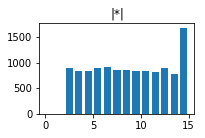

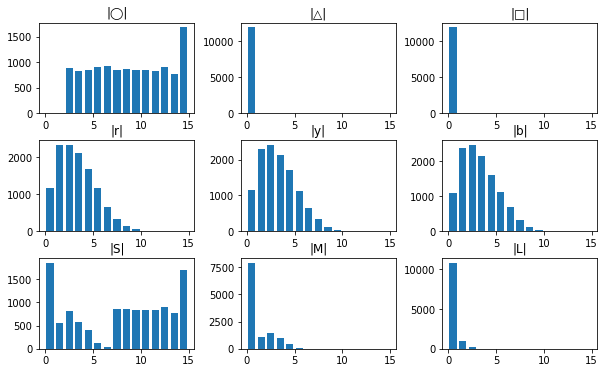

<IPython.core.display.Javascript object>

CPU times: user 32.4 s, sys: 1.43 s, total: 33.9 s
Wall time: 33.2 s


In [53]:
#@title Create Training/Validation Set. Show Training Set (f, fig_cfg) { vertical-output: true }
%%time

batch_size      = 21 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 12000 #@param {type:"slider", min:100, max:20000, step:100}
validation_size = 1000 #@param {type:"slider", min:100, max:1500, step:10}

params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

training_generator = DataGenerator(set_path="train", samples=training_size, **params).renderFrame()
validation_generator = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

training_generator.panda.display_meta(params['figure_parameters'])



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
9,0,9,train/fig000009,1 red circles,"[0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0]",fig000009.png,6,0,4,2,1,1,4,0,0,6
10,0,10,train/fig000010,2 red circles,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1]",fig000010.png,12,0,0,12,5,2,5,0,0,12
11,0,11,train/fig000011,6 red circles,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000011.png,15,0,0,15,6,6,3,0,0,15
12,0,12,train/fig000012,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 1, 0, 0]",fig000012.png,12,0,0,12,5,4,3,0,0,12
13,0,13,train/fig000013,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 1]",fig000013.png,10,0,0,10,2,3,5,0,0,10
14,0,14,train/fig000014,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 1, 0]",fig000014.png,12,0,0,12,5,3,4,0,0,12
15,0,15,train/fig000015,0 red circles,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000015.png,9,0,0,9,6,0,3,0,0,9
16,0,16,train/fig000016,2 red circles,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000016.png,11,0,0,11,6,2,3,0,0,11
17,0,17,train/fig000017,5 red circles,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 1, 0]",fig000017.png,15,0,0,15,6,5,4,0,0,15
18,0,18,train/fig000018,2 red circles,"[0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 1]",fig000018.png,12,0,0,12,5,2,5,0,0,12


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,
,
,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([1, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 1, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

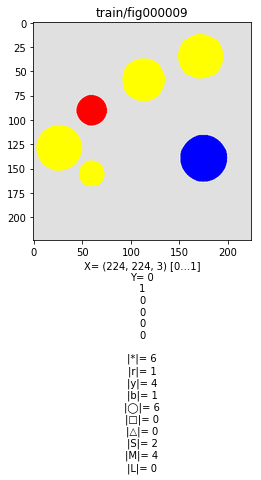

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

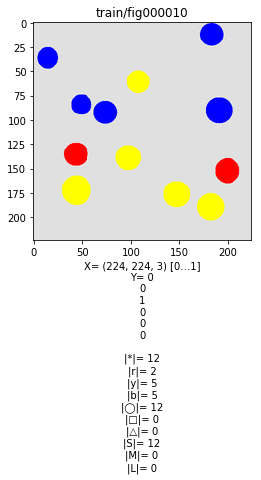

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

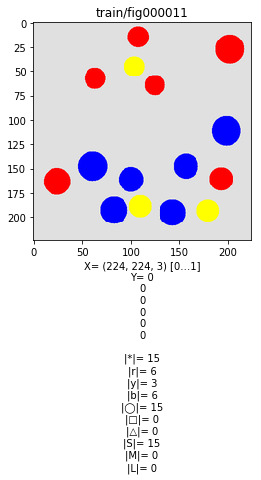

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

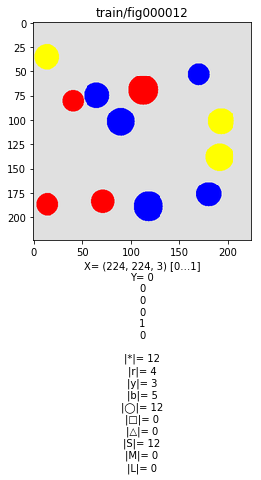

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

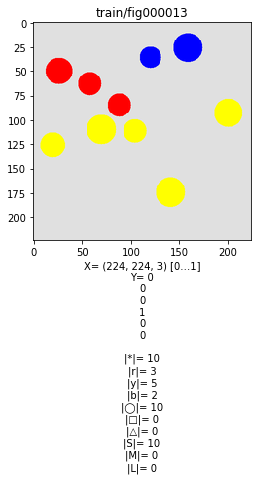

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

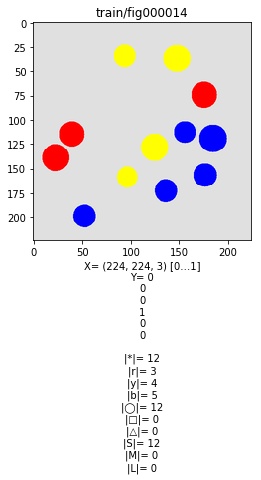

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

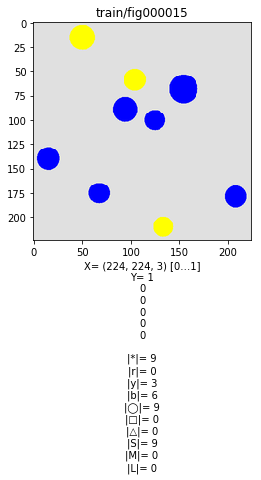

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

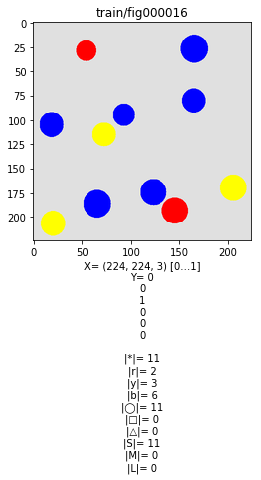

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

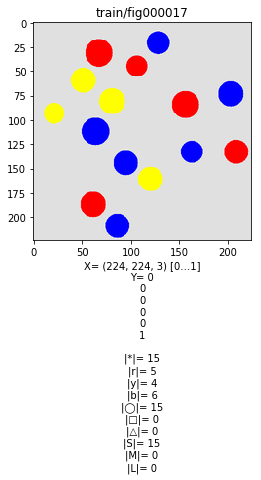

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

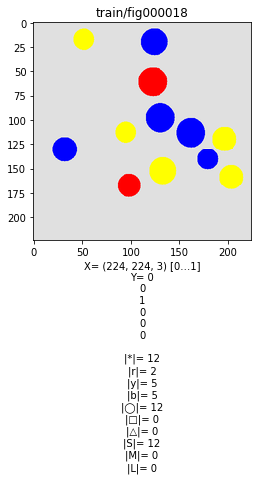

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

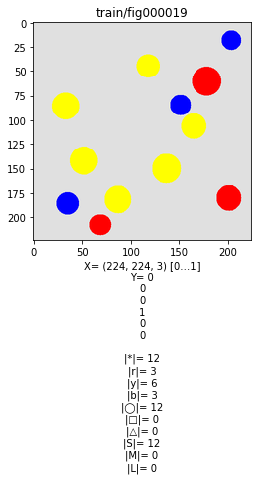

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

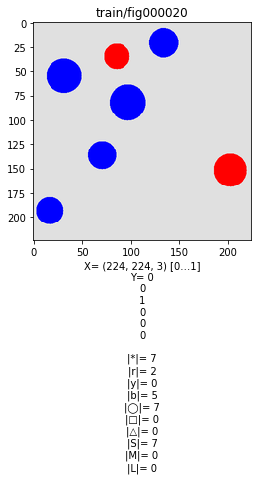

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

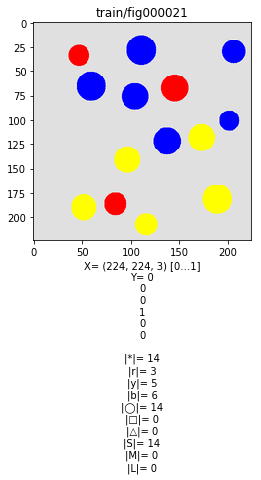

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

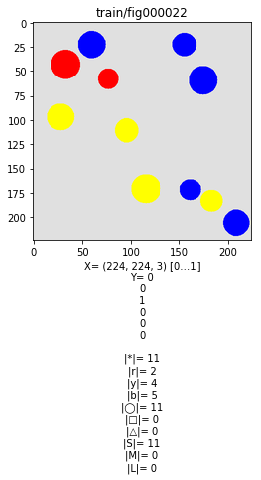

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

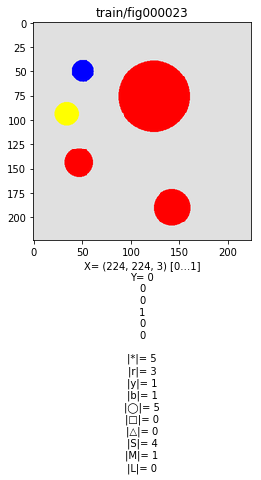

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

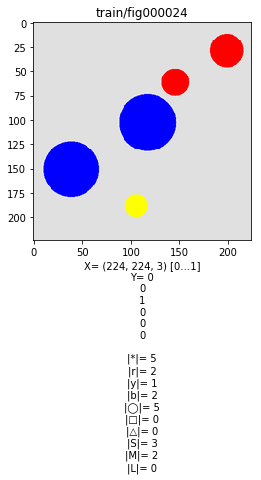

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

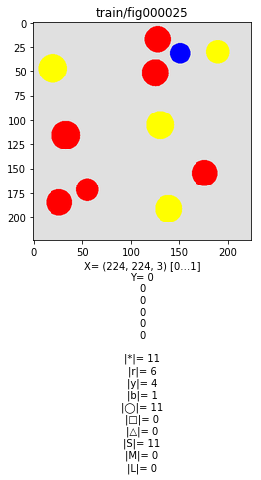

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

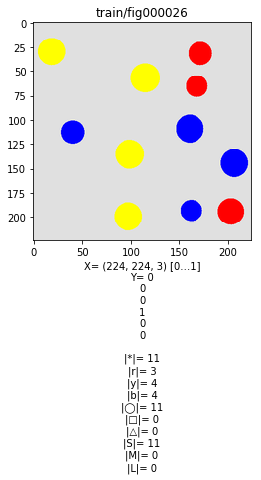

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

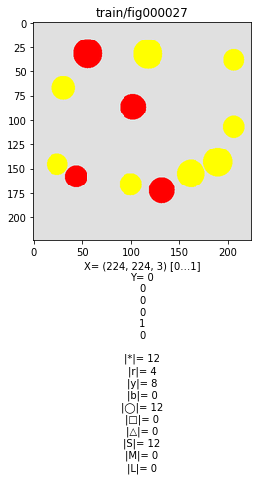

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

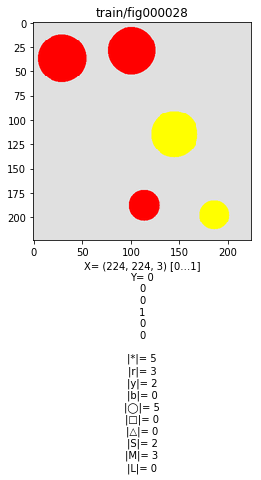

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [54]:
#@title Review Training Generator Content (X, Y, f) (Sample View) { run: "auto", vertical-output: true }

sample_to_view  = 9 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 20 #@param {type:"slider", min:1, max:20, step:1}

training_generator.panda.display_content_slice(slice(sample_to_view, sample_to_view + view_len))



In [55]:
#@title Second time sould be Faster. (images are already cached) { vertical-output: true }
%%time

training_generator = DataGenerator(set_path="train", samples=training_size,   **params).renderFrame()
validation_generator = DataGenerator(set_path="valid", samples=validation_size, **params).renderFrame()

571 train Batches touched (train)
47 valid Batches touched (valid)
CPU times: user 31 s, sys: 947 ms, total: 32 s
Wall time: 32 s


# Just for Fun: Remove some Samples from Training Set


shape= (10811, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']

sklearn classweights=  [1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10811 entries, 0 to 11990
Data columns (total 17 columns):
BID          10811 non-null int64
BPOS         10811 non-null int64
ID           10811 non-null object
Yreadable    10811 non-null object
enc|r|       10811 non-null object
enc|y|       10811 non-null object
file         10811 non-null object
|*|          10811 non-null int64
|L|          10811 non-null int64
|M|          10811 non-null int64
|S|          10811 non-null int64
|b|          10811 non-null int64
|r|          10811 non-null int64
|y|         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

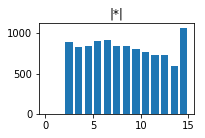

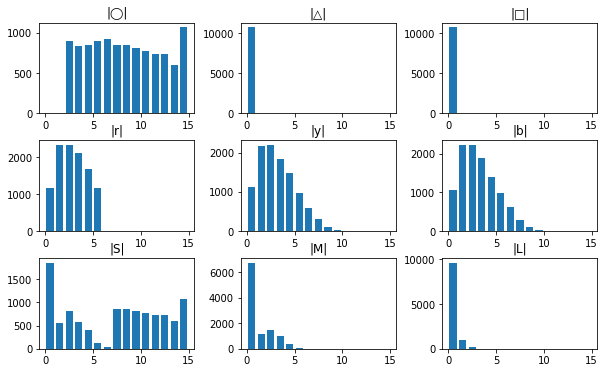

<IPython.core.display.Javascript object>

In [56]:
#@title Select Classes (training_panda → training_panda_filterd) { vertical-output: true }

#training_generator.panda = training_generator.panda.astype({"Yreadable": str})
#training_generator.panda = training_generator.panda.infer_objects()

def filter_panda(panda):
    return panda.loc[panda['Yreadable'].isin([# ['%d red circles'%i for i in range(0, 5+1)]
        '0 red circles', 
        '1 red circles', 
        '2 red circles', 
        '3 red circles', 
        '4 red circles',
        '5 red circles',
    ])]

training_panda_filterd = PandaSet(filter_panda(training_generator.panda.f), training_generator)
validation_panda_filterd = PandaSet(filter_panda(validation_generator.panda.f), validation_generator)

training_panda_filterd.display_meta(params['figure_parameters'])

# Generator Chain

In [0]:
from keras.preprocessing.image import ImageDataGenerator

argumented_training_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 180,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = [1, 1.5],
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)
argumented_validation_generator = ImageDataGenerator(rescale=1./255)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
0,0,0,train/fig000000,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000000.png,7,0,0,7,1,3,3,0,0,7
1,0,1,train/fig000001,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000001.png,6,0,2,4,1,3,2,0,0,6
2,0,2,train/fig000002,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0]",fig000002.png,13,0,0,13,3,4,6,0,0,13


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,
,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

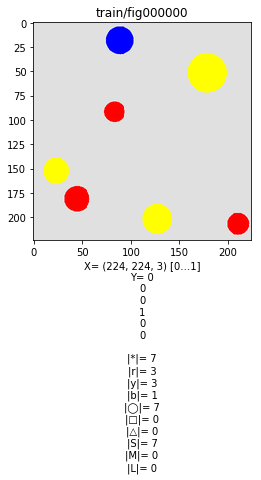

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

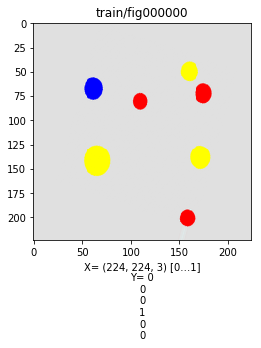

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

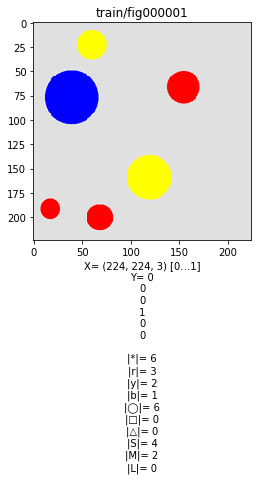

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

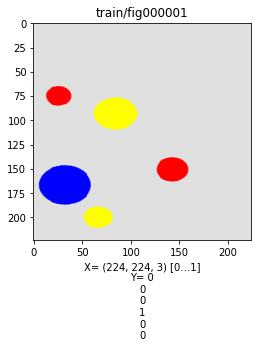

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

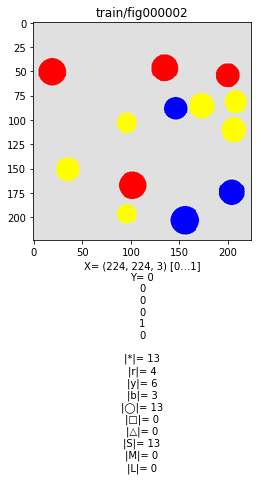

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

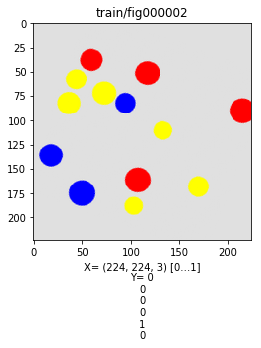

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
#@title Data Augmentation and Y Declaration { vertical-output: true }

class AugmentationGenerator(Sequence): # same element count, but transformed elements
    def __init__(self, decorated):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.last_batch_id = None
        
    def __len__(self):        
        return len(self.decorated)

    def __getitem__(self, idx):         
        X, Y, = self.getBatchCached(idx)
        for i in range(len(X)):        
            X[i] = argumented_training_generator.random_transform(X[i])            
        return X, Y
    
    def getBatchCached(self, idx):
        if not self.last_batch_id or self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
class FromFrameGenerator(Sequence): # filters elements
    def __init__(self, decorated, panda_frame):        
        self.decorated = decorated
        self.batch_size = decorated.batch_size
        self.panda_frame = panda_frame
        self.last_batch_id = None
        
    def __len__(self):        
        return int(len(self.panda_frame) / self.batch_size)

    def __getitem__(self, idx):
        batch_panda = self.panda_frame.iloc[idx*self.batch_size : (idx+1)*self.batch_size]
        X = list()
        Y = list()
        last_batch_id = None
        for i, (row_idx, sample_row) in enumerate(batch_panda.iterrows()):
            current_batch_id = sample_row['BID']   
            current_batch_pos = sample_row['BPOS']            
            batch = self.getBatchCached(current_batch_id)
            X.append(batch[0][current_batch_pos])
            Y.append(batch[1][current_batch_pos])
        
        return np.array(X), np.array(Y)
    
    def getBatchCached(self, idx):
        if not self.last_batch_id or self.last_batch_id != idx:
            self.last_batch = self.decorated[idx]
            self.last_batch_id = idx
        return self.last_batch
    
filtered = PandaSet(
    training_panda_filterd.f, 
    FromFrameGenerator(training_generator, training_panda_filterd.f)
)

augmented = PandaSet(
    training_panda_filterd.f, 
    AugmentationGenerator(filtered.generator)
)

augmented.display_content_slice(
    slice(0, 3),
    assert_view = lambda s, r, ridx, g: s.plot(        
        X=g[r['BID']][0][r['BPOS']], 
        Y=g[r['BID']][1][r['BPOS']]
    )
)


#filtered.generator[0]

# Flow from Data Frame Generator

In [59]:
#@title Data Augmentation and Y Declaration { vertical-output: true }
    
def convert_for_keras(panda):
    select_keras = panda.copy() #select3.sort_values(by=['Yreadable'])
    select_keras.loc[:,'Yreadable'] = select_keras.loc[:,'Yreadable'].astype('category')
    select_keras.loc[:,'|r|']       = select_keras.loc[:,'|r|'].astype('category')
    select_keras.loc[:,'|y|']       = select_keras.loc[:,'|y|'].astype('category')
    select_keras.loc[:,'file']      = select_keras.loc[:,'file'].astype(str)    
    #print("\nselect_keras dtypes=\n", select_keras.dtypes)
    print("\nclasses in Yreadable=", np.unique(select_keras['Yreadable']))
    return select_keras

from_frame_args = dict(    
    # mode automatisch zu onehot convertiert (wenn man ihm auch die classes gibt?)    
    # 'categorical' for string?
    # 'other' for  if Y is int
    y_col = 'Yreadable', #'enc|r|', #'|r|', # ja wirklich nicht Y, weil ImageDataGenerator im categorical 
    class_mode = 'categorical',        
)

from_frame_args = dict(
    y_col = 'Yreadable', #'enc|r|', #'|r|', # ja wirklich nicht Y, weil ImageDataGenerator im categorical 
    class_mode = 'categorical',        
    
    #y_col = ['|r|', '|y|'],
    #class_mode = 'raw',
    
    x_col = 'file',    
    batch_size = batch_size,
    target_size = image_shape,
    shuffle = False
)
    
training_generator_from_table = argumented_training_generator.flow_from_dataframe(
    dataframe = convert_for_keras(training_panda_filterd.f),
    directory = './images/train/',
    **from_frame_args
)

print("Y=", training_generator_from_table[0][1].shape)
print("Y=", training_generator_from_table[0][1])

validation_generator_from_table = argumented_validation_generator.flow_from_dataframe(
    dataframe = convert_for_keras(validation_panda_filterd.f),
    directory = './images/valid/',
    **from_frame_args
)


classes in Yreadable= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']
Found 10811 images belonging to 6 classes.
Y= (21, 6)
Y= [[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]

classes in Yreadable= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']
Found 885 images belonging to 6 classes.


# Flow from Directory Generator

In [60]:
!mkdir images_categorical
!mkdir images_categorical/train
!mkdir images_categorical/test

#!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/kandinsky_color_large.tar.gz -vP images_categorical      
#!tar -xzf  images_categorical/kandinsky_color_large.tar.gz -C images_categorical/train

#!mv images_categorical/train/A/test images_categorical/test/A
#!mv images_categorical/train/B/test images_categorical/test/B
#!mv images_categorical/train/C/test images_categorical/test/C
#!mv images_categorical/train/D/test images_categorical/test/D
#!mv images_categorical/train/E/test images_categorical/test/E
#!mv images_categorical/train/F/test images_categorical/test/F

mkdir: cannot create directory ‘images_categorical’: File exists
mkdir: cannot create directory ‘images_categorical/train’: File exists
mkdir: cannot create directory ‘images_categorical/test’: File exists


In [0]:
# OR: foreach panda row
#          move file to targetpath/Yast/i_nr.png

In [62]:
training_generator_from_directory = argumented_training_generator.flow_from_directory(
    directory = 'images_categorical/train',
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

validation_generator_from_directory = argumented_validation_generator.flow_from_directory(
    directory = 'images_categorical/test',
    target_size = image_shape,
    batch_size = batch_size,
    shuffle = False
)

class_weight_from_directory = sklearn_class_weight_from_vector(training_generator_from_directory.classes)
print(np.unique(training_generator_from_directory.classes))
print(class_weight_from_directory)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.
[]
[1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]


# Data ready - Load  VGG16

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

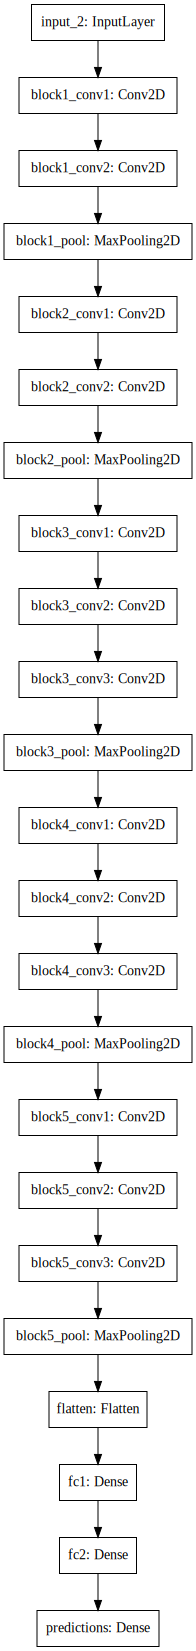

In [63]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }

vgg16_init_weights = 'imagenet' #@param ["'imagenet'", "None"] {type:"raw"}

from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights=vgg16_init_weights)
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

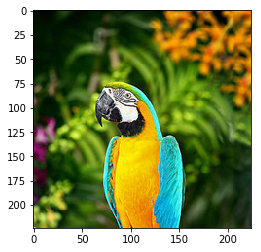

79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [64]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }

from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

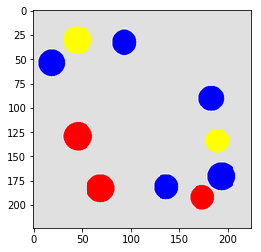

 6.48% : envelope
 3.31% : mosquito_net
 3.14% : shower_curtain
 2.90% : toilet_tissue
 2.15% : photocopier


In [65]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# Creating a Model: VGG16[0:block5_pool] + 2 new Dense Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6150      
Total params: 40,411,974
Trainable params: 40,411,974
Non-trainable params: 0
_________________________________________________________________


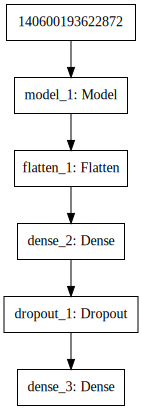

In [66]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

In [67]:
#@title Compile after trainable Layers are set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 0.01                       #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = True #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(
    optimizer = Adam(lr=1e-5), 
    loss = loss, 
    metrics = [main_metric]
)

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

True True True True True True True True True True True True True True True True True True True 



# Training

In [0]:
#used_training_generator = training_generator                   # from DataGenerator implementation (files already created, may loads figures and images, but X is transfered in memory)
#used_training_generator = training_generator_from_table         # flow_from_dataframe (from panda frame)
#used_training_generator = training_generator_from_directory    # flow_from_directory (hvass style)            geht mit tar.gz download oder hier figures generieren
used_training_generator = augmented.generator

used_validation_generator = validation_generator_from_table
#used_validation__generator = validation__generator_from_table
#used_validation_generator = validation_generator_from_directory

#class_weight = class_weight_raw
class_weight = training_panda_filterd.class_weight
#class_weight = class_weight_from_directory

In [0]:
#show_batches(validation_generator)
#show_batches(validation_generator_from_table)
#show_batches(validation_generator_from_directory)


Raw: len=571, batch_size=21


,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

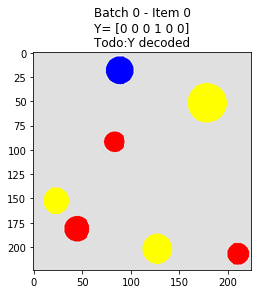

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

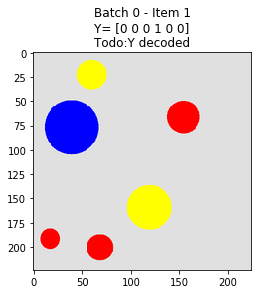

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

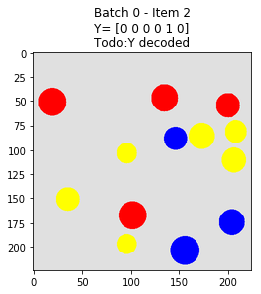

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

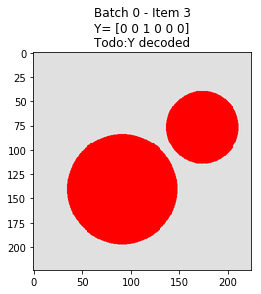

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

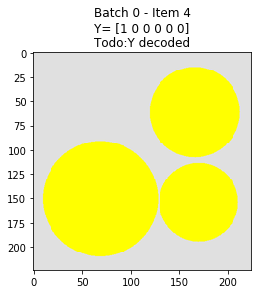

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

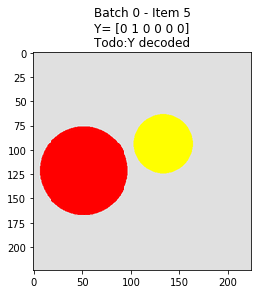

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

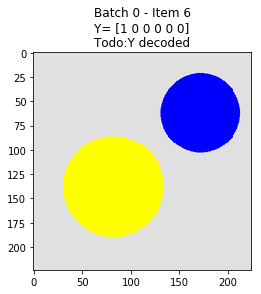

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

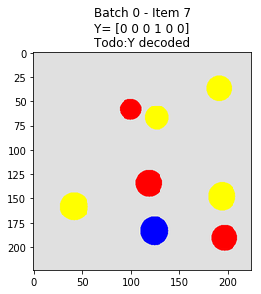

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

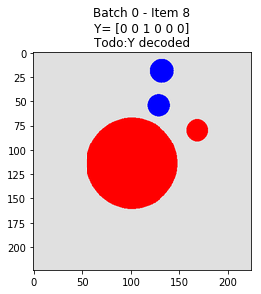

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

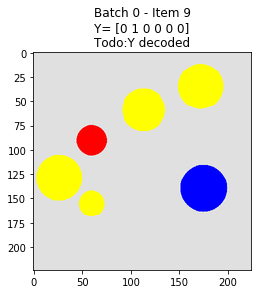

<IPython.core.display.Javascript object>


Table: len=515, batch_size=21


,,,,,,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

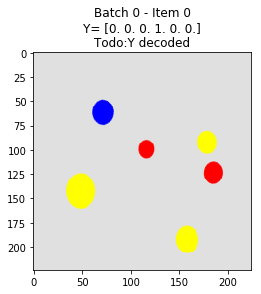

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

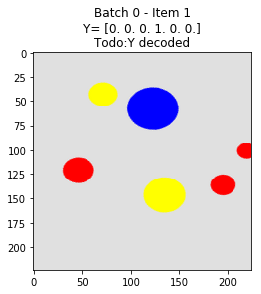

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

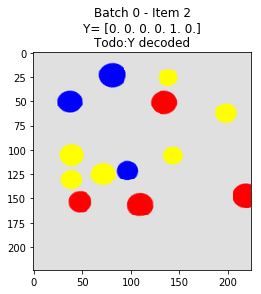

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

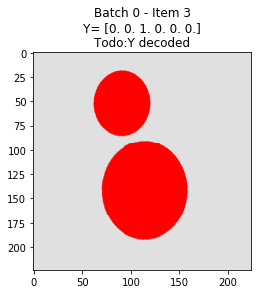

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

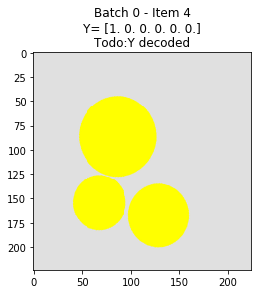

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

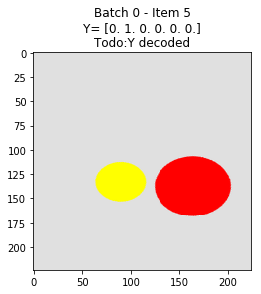

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

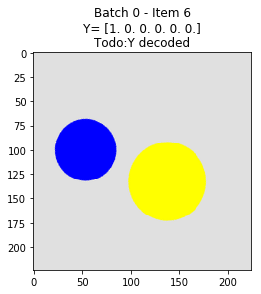

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

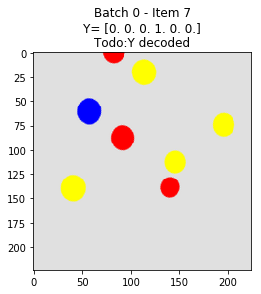

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

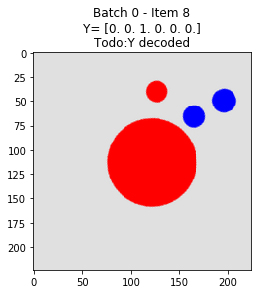

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

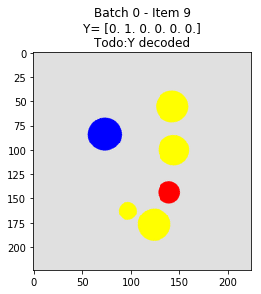

<IPython.core.display.Javascript object>

In [70]:
#@title View Generators. only with (X, Y) (imshowXView) { run: "auto", vertical-output: true }
#https://colab.research.google.com/notebooks/widgets.ipynb#scrollTo=P6xc9QVFSlrw

def show_batches(name, generator):    
    print("\n%s: len=%d, batch_size=%d"%(name, len(generator), generator.batch_size))
    #generator.reset()?
    
    batch_to_view = 0 #@param {type:"slider", min:0, max:100, step:3}
    batch_view_len = 10 #@param {type:"slider", min:1, max:20, step:1}
    
    X = generator[batch_to_view][0]
    Y = generator[batch_to_view][1]
    
    image_count = min(batch_view_len, generator.batch_size)
    
    grid = widgets.Grid(1, batch_view_len)
    for i in range(image_count):
        with grid.output_to(0, i):        
            plt.title('Batch %d - Item %d\nY= %s\nTodo:Y decoded'%(batch_to_view, i, Y[i]))
            # assert X = Sample(id=batch*batch_size+i).X
            plt.imshow(X[i])
            plt.show()

show_batches('Raw', training_generator)
show_batches('Table', training_generator_from_table)
#show_batches('Table', augmented.generator)
#show_batches('Directory', training_generator_from_directory)


batch_size= 21 batch_count= 514 samples*= 10794 
epochs= 2 steps_per_epoch= 112 samples_per_step*= 96
Epoch 1/2
514/514 [==============================] - 227s 441ms/step - loss: 0.9327 - categorical_accuracy: 0.6012 - val_loss: 0.3207 - val_categorical_accuracy: 0.8621
Epoch 2/2
514/514 [==============================] - 223s 434ms/step - loss: 0.2353 - categorical_accuracy: 0.9172 - val_loss: 0.0705 - val_categorical_accuracy: 0.9910


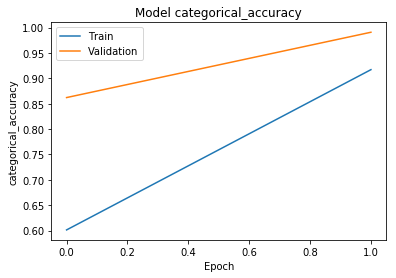

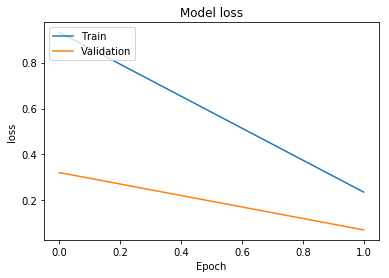

categorical_accuracy = 0.9171762
val_categorical_accuracy = 0.9909605
CPU times: user 10min 14s, sys: 1min 51s, total: 12min 6s
Wall time: 7min 33s


In [71]:
#@title Training { vertical-output: true }
%%time

steps_per_epoch    = 112 #@param {type:"slider", min:10, max:500, step:1}
epochs             = 2 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 30 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'dense' #@param ["'all'", "'dense'", "'vgg16[5,6]'"] {type:"raw"}
use_multprocessing = False #@param {type:"boolean"}
workers            = 8 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

print(
    "batch_size=", used_training_generator.batch_size, 
    "batch_count=", len(used_training_generator), 
    "samples*=", used_training_generator.batch_size * len(used_training_generator), 
    "\nepochs=", epochs, 
    "steps_per_epoch=", steps_per_epoch, 
    "samples_per_step*=", int(used_training_generator.batch_size * len(used_training_generator) 
                              / steps_per_epoch)
)

fit_result1 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

def plot_metric(history, m):        
        plt.plot(history[m])
        plt.plot(history['val_%s'%m])
        plt.title('Model %s'%m)
        plt.ylabel(m)
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()
    
def plot_history(history):    
    plot_metric(history, main_metric)
    plot_metric(history, 'loss')
    print(main_metric,          "=", history[main_metric][-1])
    print("val_%s"%main_metric, "=", history["val_%s"%main_metric][-1])

#history_merge =  merge_history(history_merge, fit_result2.history) if history_merge else fit_result1.history
history_merge = fit_result1.history
plot_history(history_merge)

514/514 [==============================] - 228s 443ms/step - loss: 0.1222 - categorical_accuracy: 0.9665 - val_loss: 0.0482 - val_categorical_accuracy: 0.9831
categorical_accuracy = 0.96646285


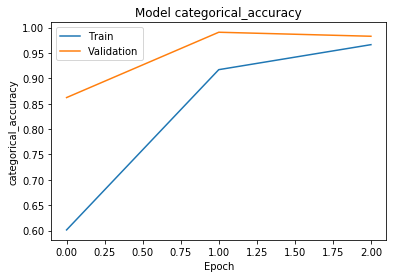

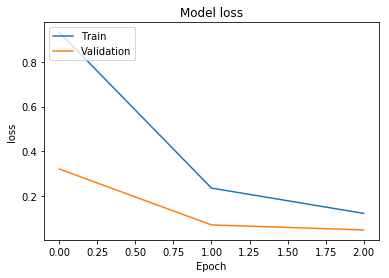

categorical_accuracy = 0.96646285
val_categorical_accuracy = 0.9830508
CPU times: user 5min 6s, sys: 56.4 s, total: 6min 2s
Wall time: 3min 48s


In [72]:
#@title Training { vertical-output: true }
%%time

epochs             = 1 #@param {type:"slider", min:1, max:50, step:1}
learning_rate      = 2 #@param {type:"slider", min:1, max:50, step:1}
trained_layers     = 'all' #@param ["'all'", "'vgg16'", "'vgg16[5,6]'"] {type:"raw"}

fit_result2 = new_model.fit_generator(    
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,    
    
    generator = used_training_generator,  
    validation_data = used_validation_generator,
    
    class_weight = class_weight,
    #use_multiprocessing = use_multprocessing,    
    #workers = workers,
    verbose = verbose
)

print(main_metric, "=", fit_result2.history[main_metric][-1])

def merge_history(h1, h2):
    assert(h1.keys() == h2.keys())
    history_merge_values = list(map(lambda ek: h1[ek] + h2[ek], h1.keys()))
    return dict(zip(h1.keys(), history_merge_values)) 
    
history_merge = merge_history(history_merge, fit_result2.history)    
plot_history(history_merge)

# Checkpoint

In [74]:
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = '/content/drive/My Drive/colab/kandinsky/%s'

In [76]:
!ls "drive/My Drive/colab/kandinsky" -l

total 631562
-rw------- 1 root root 485034872 May 31 18:03 my_model.h5
-rw------- 1 root root 161684152 May 31 21:01 my_model_weights.h5


In [0]:
#new_model.save(drive_path%'my_model.h5')
#new_model.save_weights(drive_path%'my_model_weights.h5')

In [0]:
#new_model_loaded = load_model(drive_path%'my_model.h5')

new_model_loaded = new_model
new_model_loaded.load_weights(drive_path%'my_model_weights.h5')

# Test Set 1

In [79]:
#@title Data Generators for test { vertical-output: true }
%%time
batch_size      = 31 #@param {type:"slider", min:1, max:200, step:5}
test_size       = 30000 #@param {type:"slider", min:100, max:30000, step:10}

test_params = {
    'figure_parameters': default_figure_config,
    'batch_size': batch_size,
    'in_dim': input_shape,
    'out_dim': output_shape
}

print("Figure Configuration= {\n\t%s\n}"%to_line_list(test_params['figure_parameters']))
test_generator = DataGenerator(set_path="test", samples=test_size, **test_params).renderFrame()

print("Generated class count of test set=", np.max(test_generator.panda.f['|r|']))

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}
967 test Batches touched (test)
Generated class count of test set= 12
CPU times: user 7min 49s, sys: 6.91 s, total: 7min 56s
Wall time: 7min 55s



shape= (29977, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 13

Class names= ['0 red circles' '1 red circles' '10 red circles' '11 red circles'
 '12 red circles' '2 red circles' '3 red circles' '4 red circles'
 '5 red circles' '6 red circles' '7 red circles' '8 red circles'
 '9 red circles']

sklearn classweights=  [1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29977 entries, 0 to 29976
Data columns (total 17 columns):
BID          29977 non-null int64
BPOS         29977 non-null int64
ID           29977 non-null object
Yreadable    29977 non-null object
enc|r|       29977 non-null object
enc|y|       29977 non-null object
file         29977 non-null object
|*|          29977 non-null int64
|L|          29977 non-null int64
|M|          29977 non-null in

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

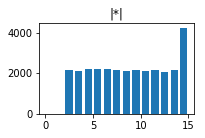

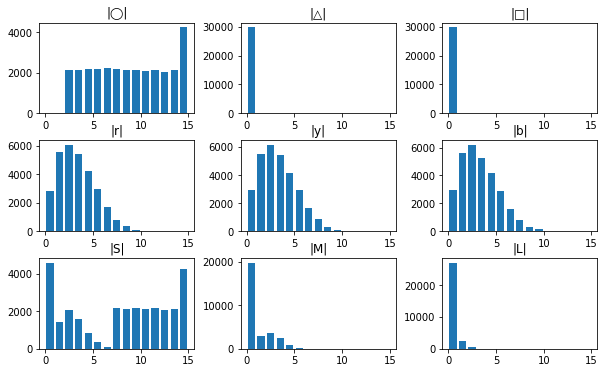

<IPython.core.display.Javascript object>

In [80]:
#@title Test set { run: "auto", vertical-output: true }
test_generator.panda.display_meta(test_params['figure_parameters'])



classes in Yreadable= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']
Found 27032 images belonging to 6 classes.

shape= (27032, 17)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles']

sklearn classweights=  [1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27032 entries, 0 to 29975
Data columns (total 17 columns):
BID          27032 non-null int64
BPOS         27032 non-null int64
ID           27032 non-null object
Yreadable    27032 non-null object
enc|r|       27032 non-null object
enc|y|       27032 non-null object
file         27032 non-null object
|*|          27032 non-null int64
|L|          27032 non-null int64
|M|          27032 non-null int64
|S|          27032 non-null int64
|b|          27032 non-null int64
|r|          27032 non-null int64
|y|         

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

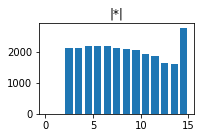

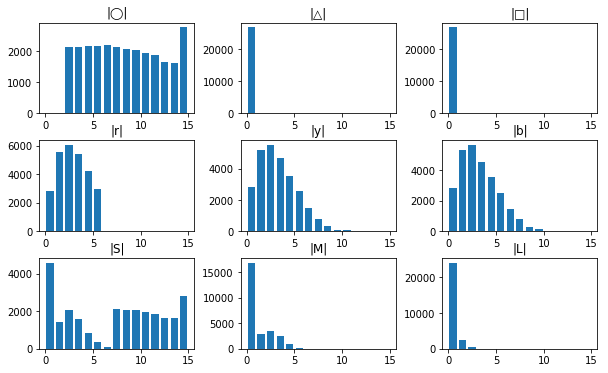

<IPython.core.display.Javascript object>

In [81]:
#@title Use same filter for test set { run: "auto", vertical-output: true }
test_panda_filterd = PandaSet(filter_panda(test_generator.panda.f), test_generator)

# ja wirklich argumented_validation_generator weil ich hier nur x laden will
test_generator_from_table = argumented_validation_generator.flow_from_dataframe(    
    dataframe = convert_for_keras(test_panda_filterd.f),
    directory = './images/test/',
    **from_frame_args
)

used_test_generator = test_generator_from_table
used_test_panda = test_panda_filterd

used_test_panda.display_meta(test_params['figure_parameters'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|
0,0,0,test/fig000000,1 red circles,"[0, 1, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0]",fig000000.png,3,0,3,0,1,1,1,0,0,3
1,0,1,test/fig000001,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000001.png,7,0,0,7,2,3,2,0,0,7
2,0,2,test/fig000002,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 0, 1, 0, 0]",fig000002.png,9,0,0,9,3,3,3,0,0,9
4,0,4,test/fig000004,3 red circles,"[0, 0, 0, 1, 0, 0]","[0, 0, 1, 0, 0, 0]",fig000004.png,7,0,0,7,2,3,2,0,0,7
5,0,5,test/fig000005,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 0, 1, 0, 0, 0]",fig000005.png,8,0,0,8,2,4,2,0,0,8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 1, 0, 0, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 1, 0, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

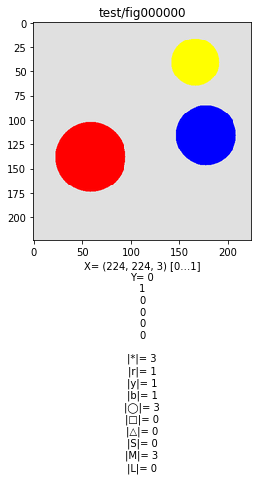

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

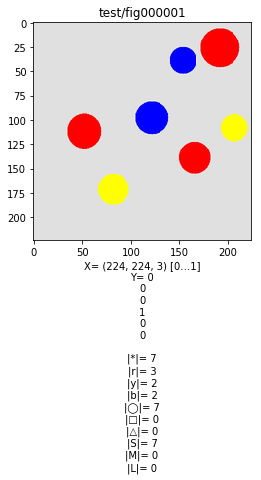

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

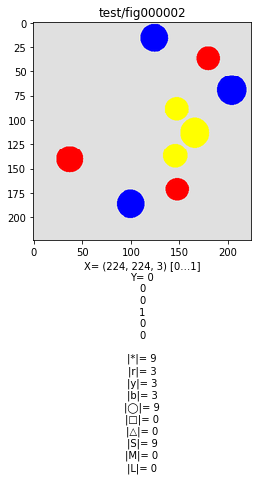

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

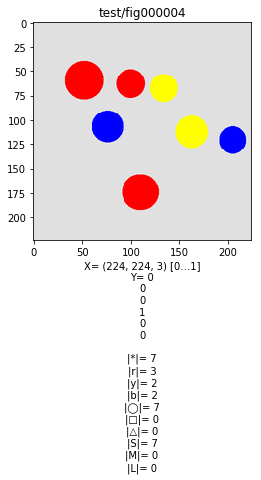

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

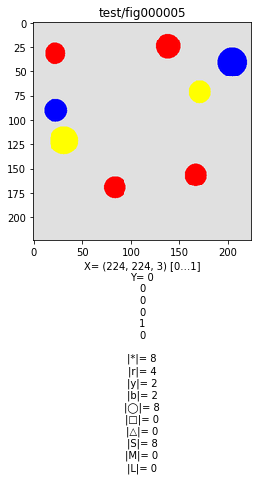

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
#@title Review Train Generator { run: "auto", vertical-output: true }

sample_to_view  = 0 #@param {type:"slider", min:0, max:20000, step:1}
view_len = 5 #@param {type:"slider", min:1, max:20, step:1}

used_test_panda.display_content_slice(slice(sample_to_view, sample_to_view + view_len))

# Evaluation 1

In [83]:
#@title Test Metrics { run: "auto", vertical-output: true }

print("Accuracy %s" % new_model.evaluate_generator(used_test_generator, verbose=1)[1])

1288/1288 [==============================] - 161s 125ms/step - loss: 0.0299 - categorical_accuracy: 0.9947
Accuracy 0.99467295


In [84]:
#@title Predict and add Prediction to panda { vertical-output: true }

y_pred = new_model.predict_generator(used_test_generator, verbose=1)
y_pred_nr = np.argmax(y_pred, axis=1)
y_pred_str = ['%d red circles'%nr for nr in y_pred_nr]

raw_panda = used_test_panda.f.copy()
raw_panda['Ypredicted'] = y_pred_str

mask = (raw_panda['Yreadable'] != raw_panda['Ypredicted'])

print("\nnumber of falsy predictions", np.sum(mask))
print("\nnumber of correct predictions", np.sum(~mask))

raw_panda['mask'] = mask



1288/1288 [==============================] - 158s 123ms/step

number of falsy predictions 144

number of correct predictions 26888



shape= (144, 19)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Figure Configuration= {
	render_size: (224, 224),
	obj_count: (2, 15),
	obj_size: (0.1, 0.5),
	colors: ['red', 'yellow', 'blue'],
	shapes: ['circle'],
}

Max |r| in training set= 6

Class names= ['1 red circles' '4 red circles' '5 red circles']

sklearn classweights=  [1.58730159 0.50505051 0.61728395 0.61728395 0.69444444 1.2345679
 1.85185185 5.55555556 5.55555556]

Panda info=
<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 109 to 29905
Data columns (total 19 columns):
BID           144 non-null int64
BPOS          144 non-null int64
ID            144 non-null object
Yreadable     144 non-null object
enc|r|        144 non-null object
enc|y|        144 non-null object
file          144 non-null object
|*|           144 non-null int64
|L|           144 non-null int64
|M|           144 non-null int64
|S|           144 non-null int64
|b|           144 non-null int64
|r|           144 non-null int64
|y|           144 non-null int64
|□|           144 non-null int64
|△|     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

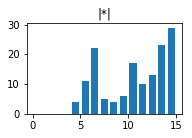

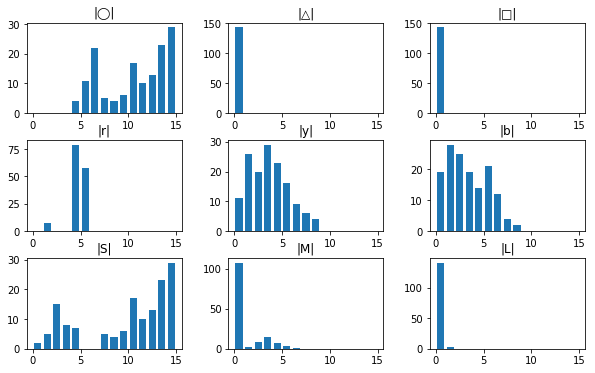

<IPython.core.display.Javascript object>

In [85]:
#@title Create Set of Errors { vertical-output: true }



error_set = PandaSet(raw_panda[mask], test_generator)

error_set.display_meta(test_params['figure_parameters'])

    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,BID,BPOS,ID,Yreadable,enc|r|,enc|y|,file,|*|,|L|,|M|,|S|,|b|,|r|,|y|,|□|,|△|,|◯|,Ypredicted,mask
7650,246,24,test/fig007650,5 red circles,"[0, 0, 0, 0, 0, 1]","[1, 0, 0, 0, 0, 0]",fig007650.png,6,0,5,1,1,5,0,0,0,6,4 red circles,True
7706,248,18,test/fig007706,5 red circles,"[0, 0, 0, 0, 0, 1]","[0, 0, 0, 1, 0, 0]",fig007706.png,8,0,0,8,0,5,3,0,0,8,4 red circles,True
8765,282,23,test/fig008765,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0]",fig008765.png,14,0,0,14,6,4,4,0,0,14,3 red circles,True
8807,284,3,test/fig008807,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 1, 0, 0, 0, 0]",fig008807.png,6,0,2,4,1,4,1,0,0,6,3 red circles,True
9054,292,2,test/fig009054,4 red circles,"[0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 1]",fig009054.png,12,0,0,12,3,4,5,0,0,12,3 red circles,True


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,
,
,
,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 0, 1])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([[[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        ...,
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137]],

       ...,

       [[0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0.87843137, 0.87843137],
        [0.87843137, 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

array([0, 0, 0, 0, 1, 0])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,,,,
,,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

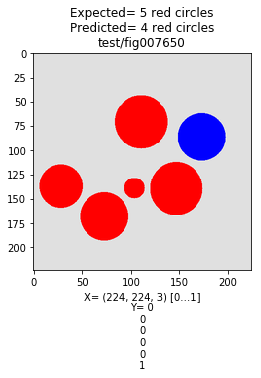

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

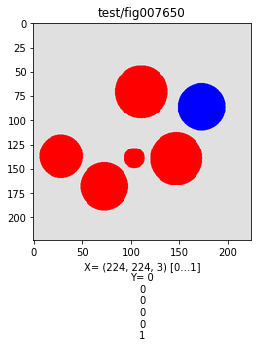

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

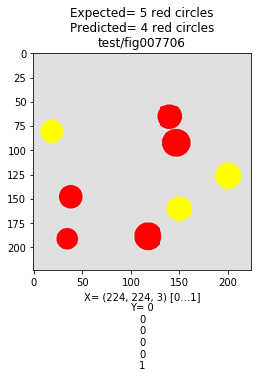

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

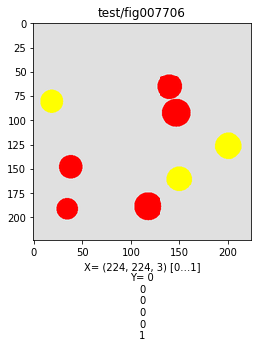

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

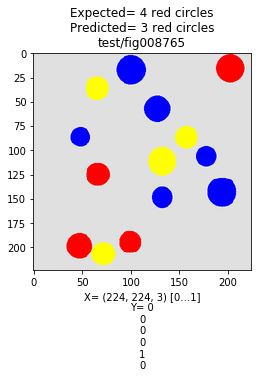

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

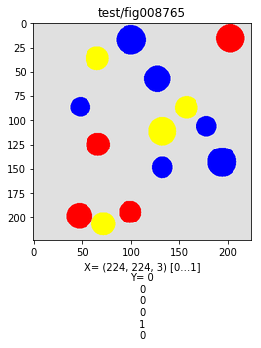

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

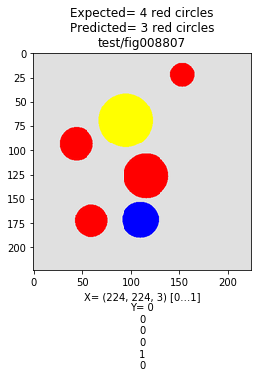

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

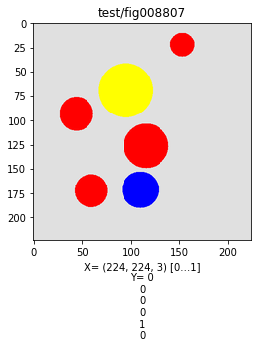

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

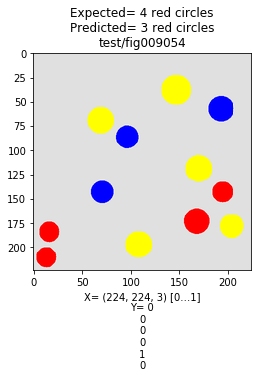

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

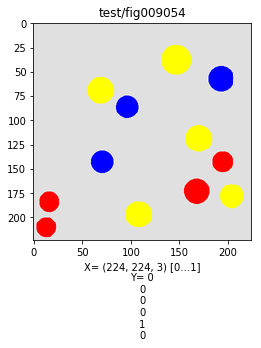

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
#@title View Error Samples { run: "auto", vertical-output: true } 
sample_to_view  = 36 #@param {type:"slider", min:0, max:10000, step:1}
view_len = 5 #@param {type:"slider", min:1, max:25, step:1}

error_set.display_content_slice(
    slice(sample_to_view, sample_to_view + view_len), 
    sample_view = lambda s, r: s.plot(verbose=0, title_prefix = "Expected= %s\nPredicted= %s"%(r['Yreadable'], r['Ypredicted'])), 
    assert_view = lambda s, r, ridx, g: s.plot(verbose=0, ),
    #Xassert = 
    #Yassert = 
)

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):    
    cm = confusion_matrix(y_true=cls_test, y_pred=cls_pred) 

    print("Confusion matrix:")        
    print(cm)    
    
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
#https://colab.research.google.com/notebooks/charts.ipynb#scrollTo=8YCVGqZkJJxT

def enable_plotly_in_cell():
    import IPython
    from plotly.offline import init_notebook_mode
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
    '''))
    init_notebook_mode(connected=False)

In [0]:
from plotly.offline import iplot
import plotly.graph_objs as go

enable_plotly_in_cell()

data = [
    go.Contour(
        z=[[10, 10.625, 12.5, 15.625, 20],
           [5.625, 6.25, 8.125, 11.25, 15.625],
           [2.5, 3.125, 5., 8.125, 12.5],
           [0.625, 1.25, 3.125, 6.25, 10.625],
           [0, 0.625, 2.5, 5.625, 10]]
    )
]
iplot(data)